In [1]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image
from keras.preprocessing.image import load_img
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.utils import plot_model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import backend as K

K.clear_session()

Using TensorFlow backend.


In [2]:
img_weight, img_height = 32, 32
channel = 3
num_classes = 43
batch_size = 32
nb_epoch = 200

In [3]:
X_train = 'data/GTSRB/Train_png/'
X_valid = 'data/GTSRB/Test_png/'

In [33]:
class_names = pd.read_csv('data/GTSRB/classes.txt').class_name.values

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    X_train,
    target_size=(img_weight, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    X_valid,
    target_size=(img_weight, img_height),
    batch_size=batch_size,
    class_mode='categorical')

nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)

Found 39209 images belonging to 43 classes.
Found 12630 images belonging to 43 classes.


In [6]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(Conv2D(filters=32, kernel_size=(3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(43))
model.add(BatchNormalization())
model.add(Activation('softmax'))

In [7]:
plot_model(model,to_file='model_gtsrb.png')

In [8]:
opt = keras.optimizers.Adam(lr=0.001, 
                            beta_1=0.9, 
                            beta_2=0.999, 
                            epsilon=10e-8, 
                            decay=0.0)

In [9]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [10]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=10, 
                              verbose=1, 
                              mode='auto', 
                              min_delta=0.0001, 
                              cooldown=0, 
                              min_lr=0.00001)

model_checkpoing = ModelCheckpoint(filepath='./gtsrb_models/epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5', 
                                   monitor='val_loss', 
                                   verbose=0, 
                                   save_best_only=True, 
                                   save_weights_only=False, 
                                   mode='auto', 
                                   period=1)

earlystop = EarlyStopping(monitor='val_loss', 
                          patience=20, 
                          verbose=1, 
                          mode='auto')

csv_logger = CSVLogger(filename='gtsrb_training_log.csv',
                       separator=',',
                       append=True)

tensorboard = TensorBoard(log_dir='./logs_gtsrb',
                histogram_freq=0,
                batch_size=64,
                write_graph=True,
                write_grads=False,
                write_images=True,
                embeddings_freq=0, 
                embeddings_layer_names=None, 
                embeddings_metadata=None)

callbacks = [reduce_lr,
             model_checkpoing,
             earlystop,
             csv_logger,
             tensorboard]

In [11]:
history = model.fit_generator(train_generator,
                    steps_per_epoch=nb_train_samples // batch_size, 
                    nb_epoch=nb_epoch,
                    shuffle=True,
                    verbose=1,
                    validation_data=validation_generator, 
                    validation_steps=nb_validation_samples // batch_size,
                    callbacks=callbacks)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=1225, shuffle=True, verbose=1, validation_data=<keras_pre..., validation_steps=394, callbacks=[<keras.ca..., epochs=200)`
  


Epoch 1/200
1225/1225 [==============================] - 26s 21ms/step - loss: 2.0928 - acc: 0.4803 - val_loss: 0.4694 - val_acc: 0.9174
Epoch 2/200
1225/1225 [==============================] - 24s 20ms/step - loss: 0.5566 - acc: 0.8999 - val_loss: 0.1780 - val_acc: 0.9672
Epoch 3/200
1225/1225 [==============================] - 23s 19ms/step - loss: 0.2915 - acc: 0.9561 - val_loss: 0.1255 - val_acc: 0.9766
Epoch 4/200
1225/1225 [==============================] - 24s 19ms/step - loss: 0.1778 - acc: 0.9769 - val_loss: 0.1175 - val_acc: 0.9745
Epoch 5/200
1225/1225 [==============================] - 24s 19ms/step - loss: 0.1234 - acc: 0.9829 - val_loss: 0.0978 - val_acc: 0.9806
Epoch 6/200
1225/1225 [==============================] - 24s 20ms/step - loss: 0.0956 - acc: 0.9861 - val_loss: 0.0779 - val_acc: 0.9831
Epoch 7/200
1225/1225 [==============================] - 23s 19ms/step - loss: 0.0750 - acc: 0.9886 - val_loss: 0.0822 - val_acc: 0.9817
Epoch 8/200
1225/1225 [==================

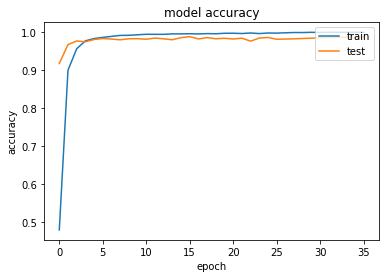

In [12]:
fig = plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
#
fig.savefig('accuracy_sgd.png')

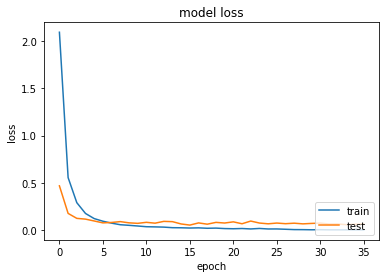

In [13]:
fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
#
fig.savefig('loss_sgd.png')

In [35]:
predict_generator = test_datagen.flow_from_directory(
                        X_valid,
                        target_size=(img_weight, img_height),
                        batch_size=1,
                        class_mode='categorical')

Found 12630 images belonging to 43 classes.


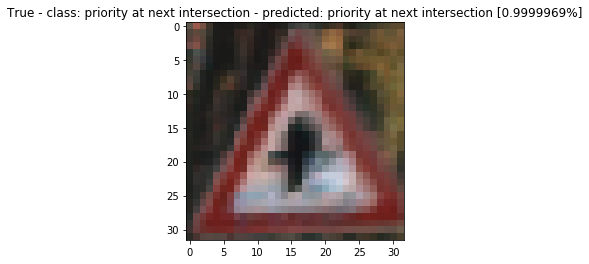

In [39]:
def predict_one(model):
    image_batch, classes_batch = next(predict_generator)
    predicted_batch = model.predict(image_batch)
    for k in range(0, image_batch.shape[0]):
        image = image_batch[k]
        pred = predicted_batch[k]
        the_pred = np.argmax(pred)
        predicted = class_names[the_pred]
        val_pred = max(pred)
        the_class = np.argmax(classes_batch[k])
        value = class_names[np.argmax(classes_batch[k])]
        plt.figure(k)
        isTrue = (the_pred == the_class)
        plt.title(str(isTrue) + ' - class: ' + value + ' - ' + 'predicted: ' + predicted + ' [' + str(val_pred) + '%]')
        plt.imshow(image)
predict_one(model)